# Weather Project by Stefano Chiesa

This project was made by **Chiesa Stefano**, as an assignment for *Python class*.
Resources used: Stackoverflow, ChatGPT, Python Lectures and Geopandas documentation.

**Original tasks**:
The dataset reports the temperature recorded in major cities around the world since 1750. Using this data, the project will need to provide an effective graphical visualization of the change in temperatures over time, highlighting the cities where the largest temperature ranges were recorded during different historical periods. For visualization of the data on a map, see geopandas.

The program will also suggest, depending on the period considered, the best route to follow for a traveler who intends to move from Beijing to Los Angeles by moving step by step to the warmest city among the 3 closest to him.

**Modifications**:
The program provides the best route between two given cities, not just between Beijing (Peking in the dataset) and Los Angeles. I also coded some functions during the testing of the Geopandas package that I kept in the final project.

## Data Cleaning
The provided had a problem with coordinates: 
_Eg. for coordinates (Latitude, Longitude): (5.63, 3.23)_

The main problem with this is that we will use the **Geopandas** package, that doesn't support this format. 
We need to convert the _"N"_ and the _"S"_ respectively in _"+"_ and _"-"_. Same with _"E"_ and _"W"_.
To fix this problem I have created the module **cleaning**, that contains the functions **convert** and **clean_data**.

In [1]:
def convert(db, column):
    if column == 'Latitude':
        for x in range(len(db[column].index)):
            if db.at[x, column][-1] == 'N':
                db.at[x, column] = '+' + db.at[x, column][0:len(db.at[x, column]) - 1]
            elif db.at[x, column][-1] == 'S':
                db.at[x, column] = '-' + db.at[x, column][0:len(db.at[x, column]) - 1]

    elif column == 'Longitude':
        for x in range(len(db[column].index)):
            if db.at[x, column][-1] == 'E':
                db.at[x, column] = '+' + db.at[x, column][0:len(db.at[x, column]) - 1]
            elif db.at[x, column][-1] == 'W':
                db.at[x, column] = '-' + db.at[x, column][0:len(db.at[x, column]) - 1]

    return db

The function **convert** changes the last value of the columns "Latitude" and "Longitude" with "+" and "-" symbols.

In [2]:
def clean_data(path):
    tem_dataframe = pd.read_csv(path, sep=',')

    # cleaning the data
    tfp_dataframe = tem_dataframe.drop(['AverageTemperatureUncertainty', 'Country'], axis=1)

    # run the functions to change the coordinates data
    tfp_dataframe = convert(tfp_dataframe, 'Latitude')
    tfp_dataframe = convert(tfp_dataframe, 'Longitude')
    # upload the modifications
    tfp_dataframe.to_csv('venv/data/data_cities.csv', index=False)
    return tfp_dataframe

Then the function *clean_data* actually does the conversion on the dataset, opening the connection and also dropping some columns we don't need for our tasks. 
Notice that this function calls *convert*, meaning that we don't need to call both of them separately: they work together.
I did this because I thought that it could be useful to have separate functions: maybe I will need to convert the pandas dataframe and not the dataset.
For the porpoise of the project, I just needed to call **clean_data** just one time, because I always worked with the same dataset.

## Preparing the basics parameters:
In this project the base of almost every function will be:
- A **geopandas dataframe** containing all the data: the data it's taken from the given dataset;
- A **geopandas dataset** containing the world map data: de data it's taken from a inbuilt geopandas' dataset (that we'll be deprecated from 2024). 

This two variables will work together to create the worldmap.

In [3]:
from map import Map
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import math

In [17]:
path = 'venv/data/data_cities.csv'
tem_dataframe = pd.read_csv(path, sep=',')  # import the data
gpd_cities = gpd.GeoDataFrame(
    tem_dataframe, geometry=gpd.points_from_xy(tem_dataframe.Longitude, tem_dataframe.Latitude)
)

gpd_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gpd_world = gpd_world[gpd_world.continent != "Antarctica"]  # removing antartica

# let's create the base object
my_map = Map(gpd_cities, gpd_world)


C:\Users\maidi\AppData\Local\Temp\ipykernel_16108\1812473655.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


## Create a World Map
Let's study the class **Map**.
The class Map has **two attributes**: the two geopandas dataframe (ds for the cities data and dw for the world map data):

In [5]:
def __init__(self, ds, dw):
    self.ds = ds  # geopandas dataframe with city data
    self.dw = dw  # geopandas dataframe with world map data

The method **create_map()** create a map that shows the cities on the worldmap.

In [6]:
def create_map(self, legend=False):
    # create a world map
    axis = self.dw.plot(color='grey', edgecolor='black')
    self.ds.plot(column='AverageTemperature', ax=axis, markersize=80, legend=legend, legend_kwds={'shrink': 0.3})
    plt.title('Average Temperatures in World Major Cities ', fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(20, 16)
    plt.show()

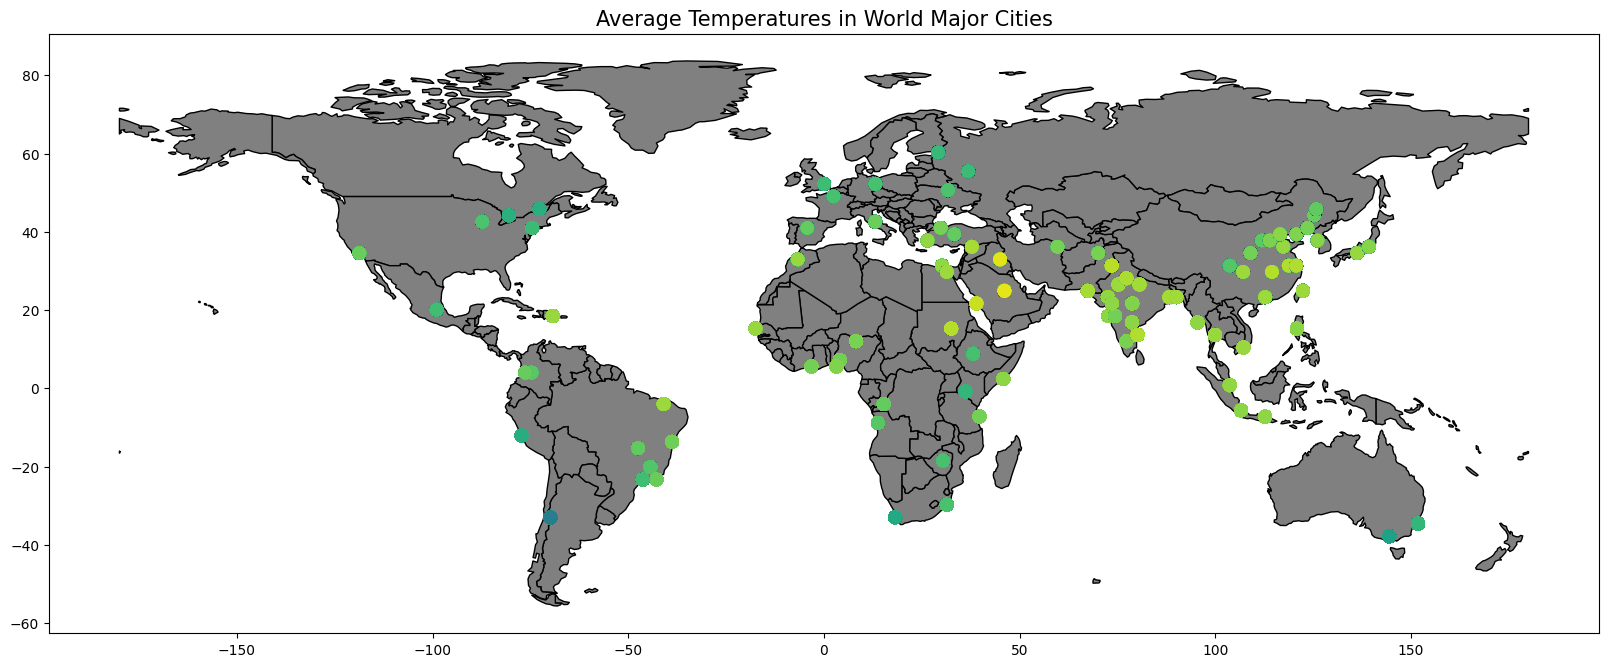

In [7]:
# call the method create_map
my_map.create_map()

The method **create_map_date** add a functionality to the previous function: it allows to choose a date in the dataset, so that you can see the average temperature in that specific day, with a legend:

In [8]:
def create_map_date(self, date):
    filtered_ds = self.ds[self.ds['dt'] == date]
    if not filtered_ds.empty:
        self.create_map(filtered_ds, self.dw, True)
    else:
        print('Data not available for the given date.')

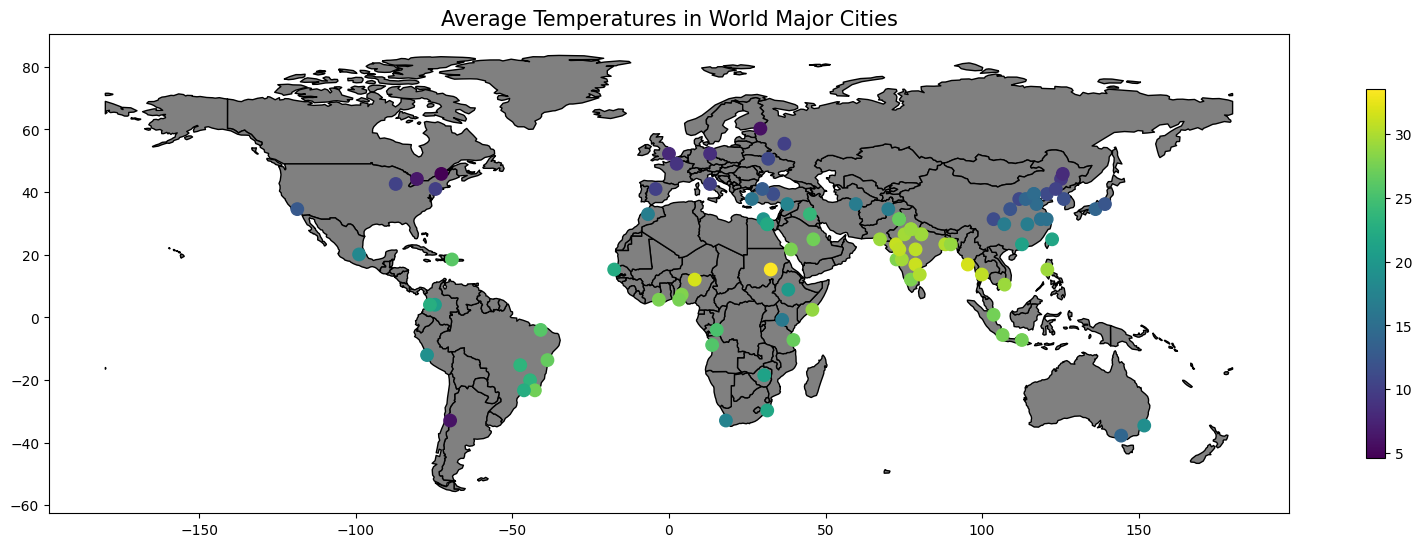

Map of 2001-04-01


In [9]:
my_map.create_map_date('2001-04-01')

The method **create_map_gif** creates a gif with the maps of the average temperatures, taking the dates from a given list of dates.

In [10]:
def create_map_gif(self, dates):
    fig, ax = plt.subplots(figsize=(20, 16))
    axis = self.dw.plot(ax=ax, color='grey', edgecolor='black')
    dates.sort()
    def update(frame):
        current_date = dates[frame]
        filtered_cities = self.ds[self.ds['dt'] == current_date]
        scatter = filtered_cities.plot(column='AverageTemperature', ax=axis, markersize=80)
        plt.title(f'Average Temperatures in World Major Cities ({current_date})', fontsize=25)
        return scatter

    def init():
        # create an empty colour with the appropriate colormap and normalization
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=-40, vmax=40))
        sm.set_array([]) # empty array for the data range
        # add the colour to the figure
        cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
        cbar.ax.tick_params(labelsize=14)
        return cbar

    animation = FuncAnimation(fig, update, frames=len(dates), interval=250, init_func=init)
    animation.save('temperature_animation.gif', fps=1) # save the gif

MovieWriter ffmpeg unavailable; using Pillow instead.


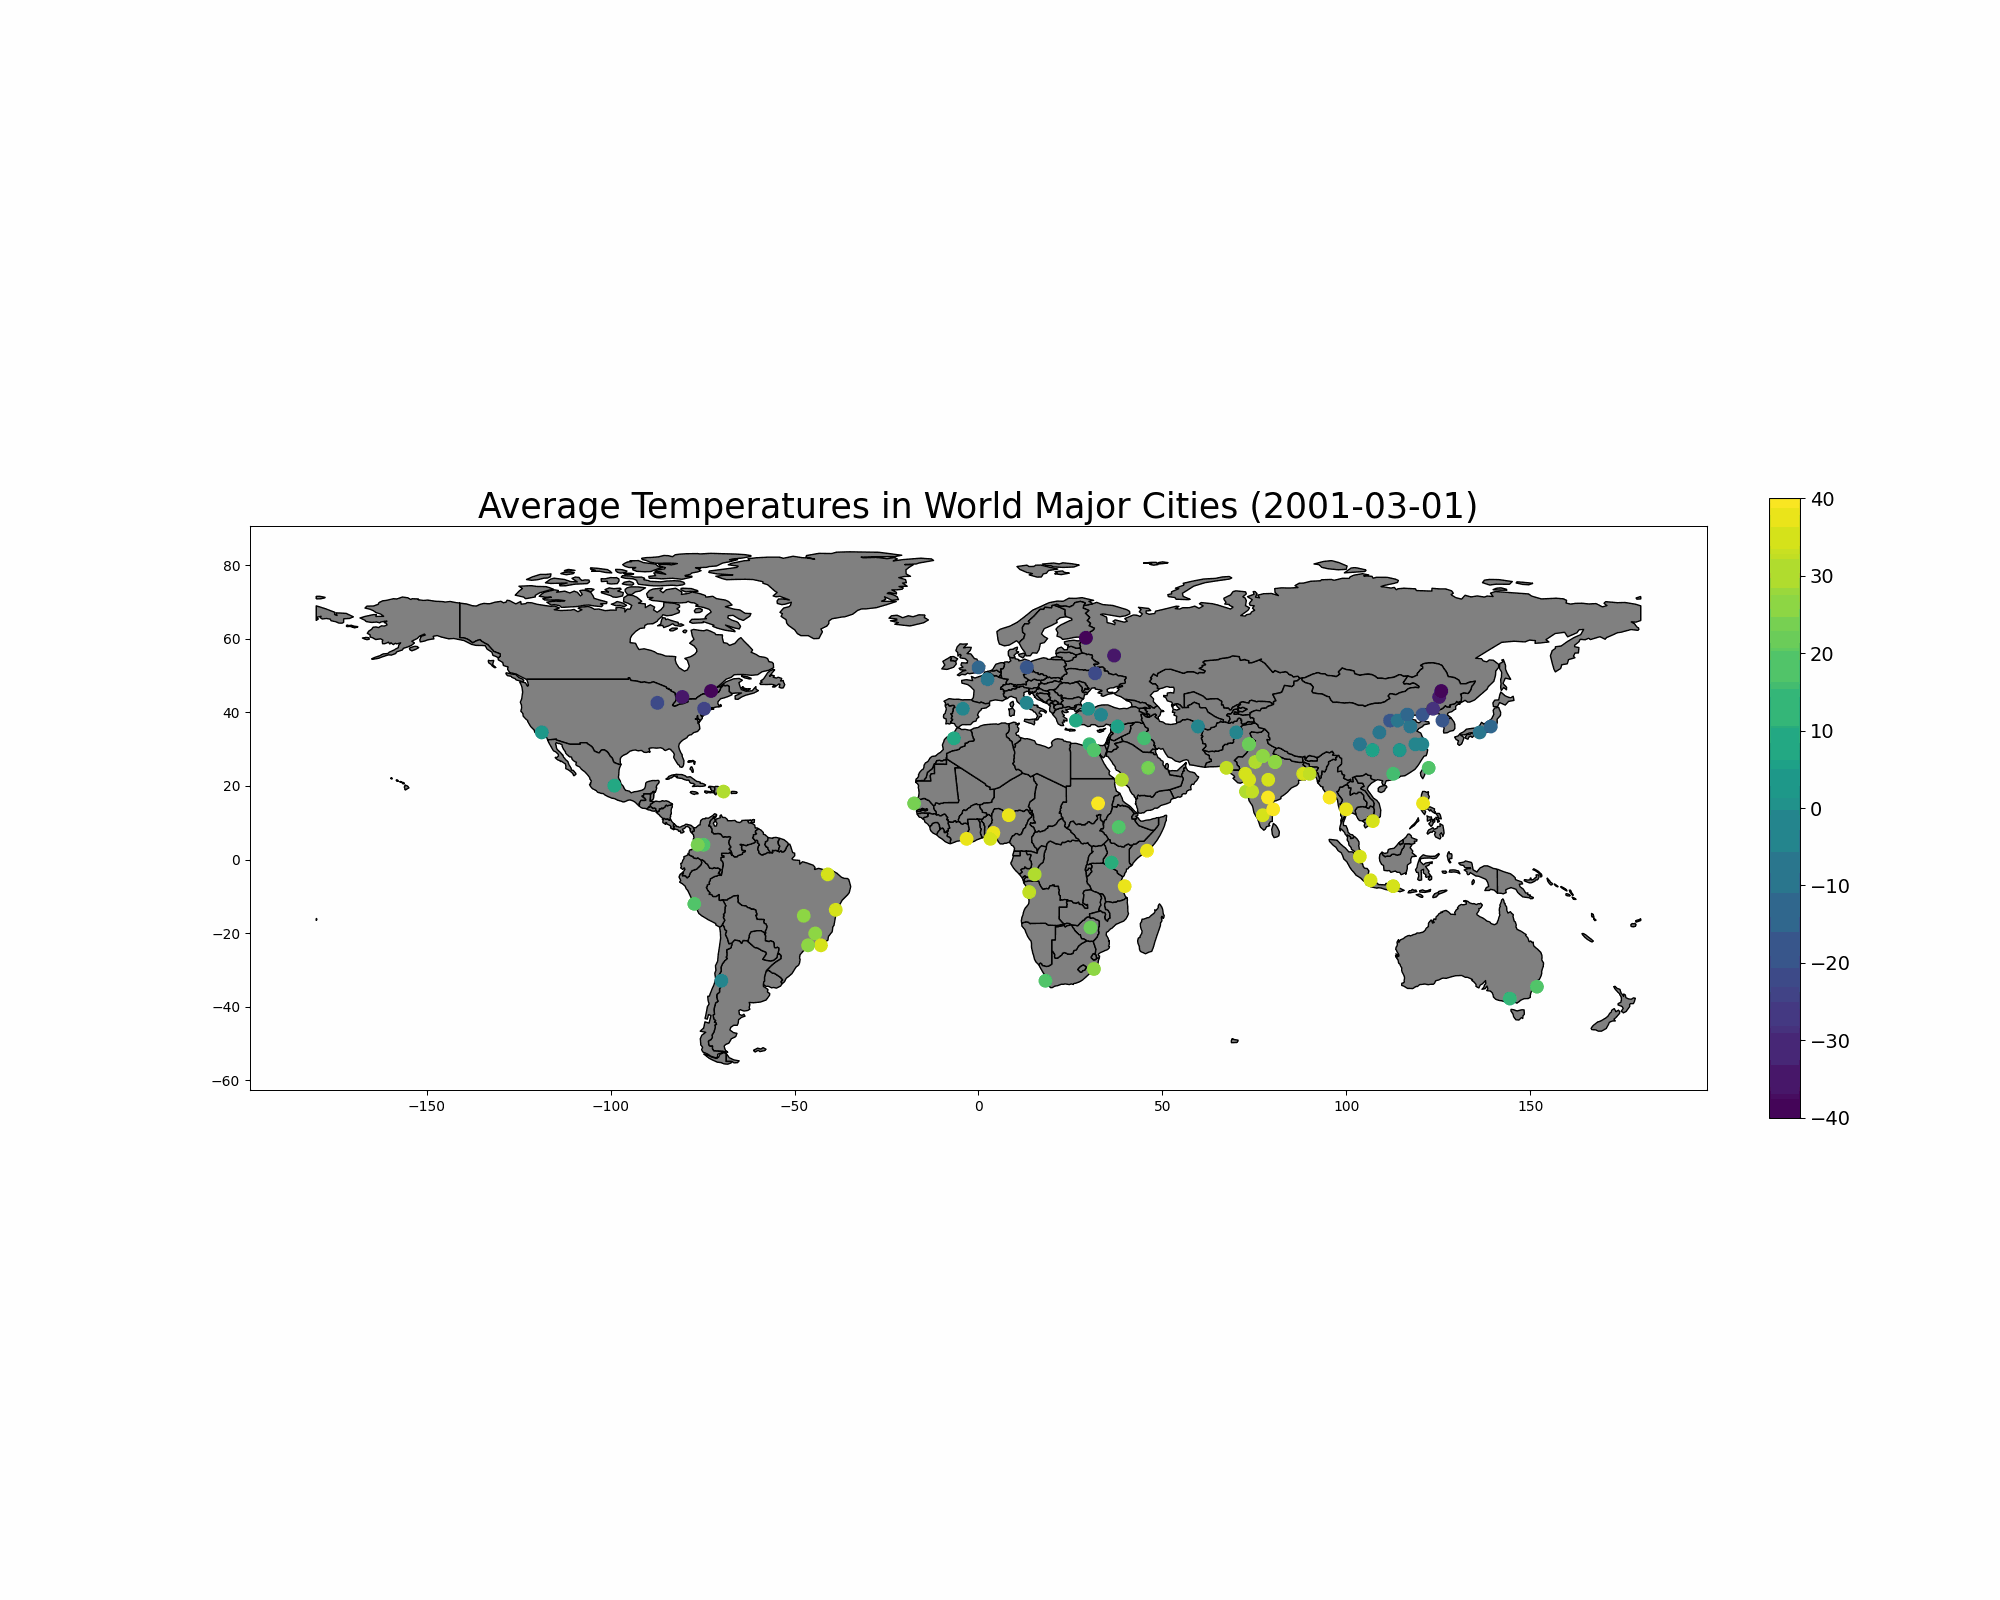

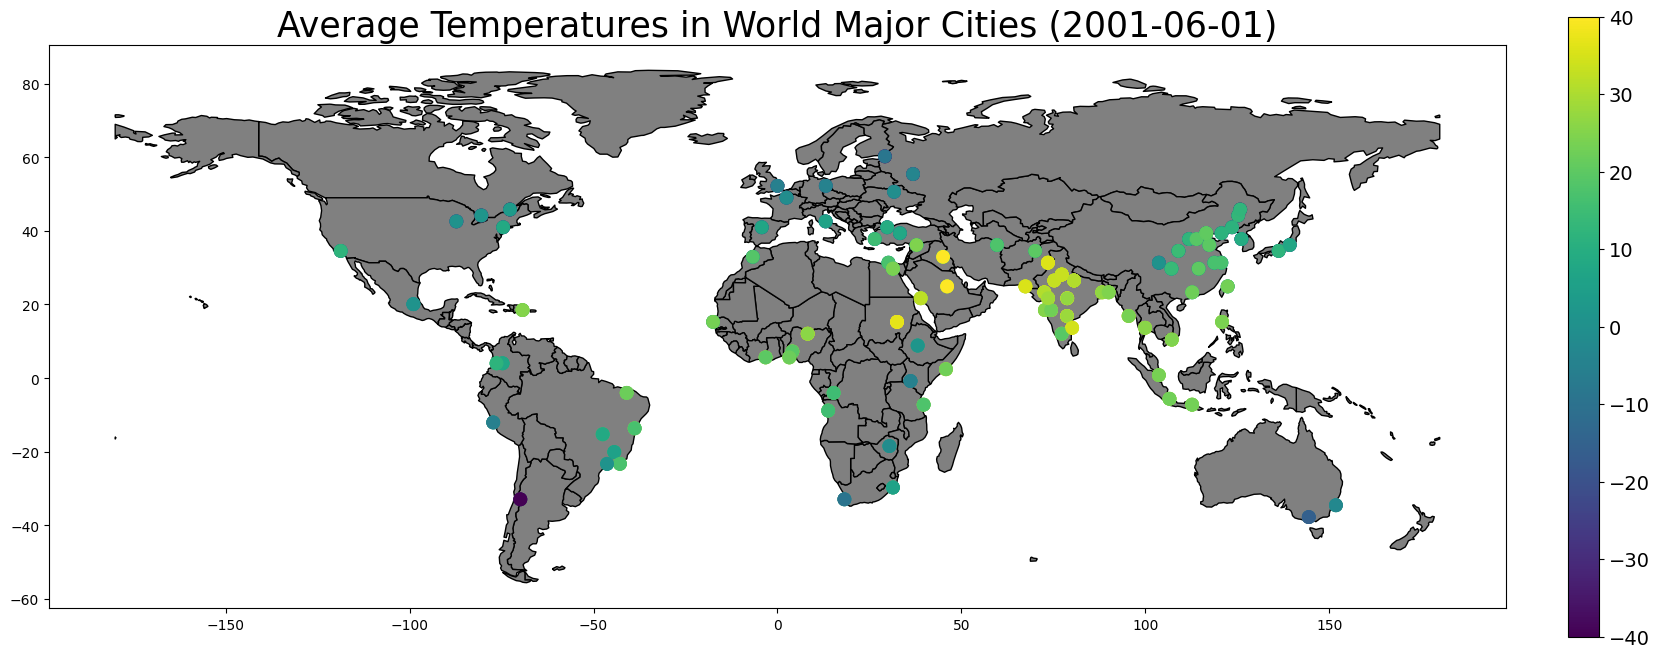

In [20]:
from IPython.display import display, Image
dates = ['2001-04-01', '2001-03-01', '2001-05-01', '2001-06-01']
my_map.create_map_gif(dates)
with open('temperature_animation_dates.gif', 'rb') as f:
    display(Image(data=f.read(), format='png'))